In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from collections import defaultdict
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
import os

In [2]:
class Vehicle:
    _id_counter = 0
    """Define vehicle attributes and rules to be implemented"""
    def __init__(self, x_position, speed, max_speed, length, width, road_designation, vehicle_type, current_row, lane_changing_prob):
        self.vehicle_id = Vehicle._id_counter  # Assign a unique ID to each vehicle
        Vehicle._id_counter += 1  #Increment the counter for the next vehicle
        self.x_position = x_position #position along the length of the road (x position)
        self.speed = speed #number of cells the vehicle will move per timestep
        self.max_speed = max_speed #maximum speed
        self.braking_prob = 0.01 #probability of random slowdown
        self.length = length #length of the vehicle is the number of cells the vehicle occupies along the length of the road
        self.width = width #width of the vehicle is the number of cells the vehicle occupies along the width of the road
        self.road_designation = road_designation #whether inside or outside
        self.vehicle_type = vehicle_type #type of vehicle is determined by the size and behavior
        self.current_row = current_row #also known as the y position of the right side of the vehicle
        self.lane_changing_prob = lane_changing_prob #probability that a vehicle will transfer lane
        self.lane_change_direction = None
        print(f"{self.vehicle_type} {self.vehicle_id} attributes")
        
    def accelerate(self):
        """Increases vehicle's speed by 1 cell, up to the maximum speed"""
        if self.speed < self.max_speed:
            self.speed += 1

    def gap_distance(self, vehicle_row_to_be_checked): 
        """Debugging this - make gap distance consider toroidal boundary cond. recently introduced"""
        """vehicle row to be checked: Input is row 0, you check for lane 1(row 0 and 1). Input is row 1, you check for lane at the middle (row 1 and 2). Input is row 2, you check for lane 2(rows 2 and 3)."""
        rear_bumper_position = self.x_position
        print(f"{self.vehicle_type} {self.vehicle_id}'s rear bumper is at {rear_bumper_position}")
        front_bumper_position = rear_bumper_position + self.length - 1
        print(f"{self.vehicle_type} {self.vehicle_id}'s front bumper is at {front_bumper_position}")
        max_distance = self.speed #maximum distance checked is equivalent to speed
        print(f"{self.vehicle_type} {self.vehicle_id}'s maximum distance is  {max_distance}")
        road_length = self.road_designation.road_length
        #print(f"{self.vehicle_type} {self.vehicle_id}'s road has length of {road_length}")
        
        gap_distance = max_distance
        #print(f"{self.vehicle_type} {self.vehicle_id}: default gap distance is {gap_distance}")
        
        for distance in range(1, max_distance + 1):
            start_of_space_to_be_checked = (rear_bumper_position + self.length + distance - 1)  % road_length
            #print(f"{self.vehicle_type} {self.vehicle_id}: next rear bumper position is {start_of_space_to_be_checked}")
            end_of_space_to_be_checked = (front_bumper_position + max_distance)  % road_length #We have to include the front bumper position, to avoid vehicle overlaps
            #print(f"{self.vehicle_type} {self.vehicle_id}: next front bumper position is {end_of_space_to_be_checked}")
            
            # Check if there's an occupied space within the distance
            if start_of_space_to_be_checked < end_of_space_to_be_checked:
                #print(f"Checking occupancy from {start_of_space_to_be_checked} to {end_of_space_to_be_checked} in row {vehicle_row_to_be_checked}")
                #print(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    print(np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]))
                    break
            else:  # Wrap-around case
                #print(f"Checking occupancy wrap-around from {start_of_space_to_be_checked} to end and from start to {end_of_space_to_be_checked} in row {vehicle_row_to_be_checked}")
                #print(self.road_designation.road_occupancy[start_of_space_to_be_checked:, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                #print(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width])
                if np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0: #or \
                   #np.sum(self.road_designation.road_occupancy[:end_of_space_to_be_checked + 1, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]) != 0:
                    gap_distance = distance - 1
                    print(np.sum(self.road_designation.road_occupancy[start_of_space_to_be_checked, vehicle_row_to_be_checked:vehicle_row_to_be_checked + self.width]))
                    break
        if gap_distance < 0: #For debugging
            print(f"Error, negative gap distance of {gap_distance}, at rear bumper position {current_x_position}") #Results to negative headway distance
        print(f"{self.vehicle_type} {self.vehicle_id} has a gap distance of {gap_distance}")
        return gap_distance # Return the  gap distance

    def lane_changing(self):
        """attempts to change lanes based on vehicle type and lane availability
        Here, we define a lane as a space of 2 cells wide. We assume a two-lane road(4 cells wide).
        We assume that each half lane is an array, imagine a vertical stack of arrays, indexing is 0 to 4 (bottom to top). Right side is the bottom."""
        #new_row = self.current_row #by default, vehicle stays on its lane
        print(f"Vehicle {self.vehicle_id} is located at row {self.current_row} with a speed of {self.speed}")
        gap_distance_of_own_lane = self.gap_distance(self.current_row) #obtains the gap distance of current lane
        print(f"{self.vehicle_type}{self.vehicle_id} has a gap distance of {gap_distance_of_own_lane} in its lane, vehicle row is {self.current_row}")
        gap_distance_of_adjacent_right_lane = self.gap_distance(self.current_row - 2) if self.current_row == 2 else gap_distance_of_own_lane #I can either set this equal to the current gap distance or to zero
        print(f" The adjacent right lane of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_right_lane} cells.")
        gap_distance_of_adjacent_left_lane = self.gap_distance(self.current_row + 2) if self.current_row == 0 else gap_distance_of_own_lane #I can either set this equal to the current gap distance or to zero
        print(f" The adjacent left lane of {self.vehicle_type} {self.vehicle_id} has an available space of {gap_distance_of_adjacent_left_lane} cells.")

        if self.speed > gap_distance_of_own_lane and self.speed > 0: # we cannot allow tailgated (vehicles having v = 0) vehicles to change lanes
            if self.current_row == 0 and gap_distance_of_adjacent_left_lane > gap_distance_of_own_lane: #There are specific cases wherein changing to the right or left lane is possible/legal
                self.lane_change_direction = 'left'
                #print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row:self.current_row+2+ self.width])
                if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + gap_distance_of_own_lane +self.length, self.current_row+2:self.current_row+2+ self.width]) == 0:
                    self.speed = gap_distance_of_own_lane - 1
                    if self.speed > 0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position +self.speed+self.length, self.current_row:self.current_row+self.width]) == 0: #This might be redundant with self.speed = gap distance - 1
                            self.current_row += 1  # Begin straddling
                            self.move()
                            print(f"{self.vehicle_type} {self.vehicle_id} is now straddling on row {self.current_row}")
            elif self.current_row == 2 and gap_distance_of_adjacent_right_lane > gap_distance_of_own_lane: 
                self.lane_change_direction = 'right'
                #print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row:self.current_row-2+ self.width])
                if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position +gap_distance_of_own_lane+ self.length, self.current_row-2:self.current_row-2+ self.width]) == 0:
                    self.speed = gap_distance_of_own_lane - 1
                    if self.speed>0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position +self.speed+self.length, self.current_row-self.width:self.current_row]) == 0:
                            self.current_row -= 1  # Begin straddling
                            self.move()
                            print(f"{self.vehicle_type} {self.vehicle_id} is now straddling on row {self.current_row}")
        else:
            pass
                    
        # Apply lane change (straddling)
        """print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width])
        if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width]) == 0:
            print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, new_row:new_row + self.width])
            self.current_row = new_row
            print(f"Vehicle {self.vehicle_id} is now straddling on row {new_row}")"""        
        return
        
       # self.test = 1
        #For debugging:
        #if self.speed < gap_distance_of_own_lane:
            #print(vehicle.gap_distance, gap_distance_of_own_lane, vehicle.speed)
        #if gap_distance_of_own_lane < 0:
            #print(f"{self.vehicle_type} {vehicle.vehicle_id} invalid")

    def handle_straddling(self):
        """Complete the lane change if straddling"""
        if self.current_row == 1:
                if self.lane_change_direction == 'right':
                    if self.speed > 0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position+self.length + self.speed, self.current_row]) == 0:
                            self.current_row = 0  # Complete change to the right lane
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed right lane change")
                        else:
                            self.decelerate()
                    else:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position +self.length+ 2, self.current_row]) == 0:
                            self.accelerate()
                            self.current_row = 0
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed right lane change")
                elif self.lane_change_direction == 'left':
                    if self.speed > 0:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position + self.length + self.speed, self.current_row+1]) == 0:
                            self.current_row = 2  # Complete change to the left lane
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed left lane change")
                        else:
                            self.decelerate()
                    else:
                        if np.sum(self.road_designation.road_occupancy[self.x_position+self.length:self.x_position + self.length + 2, self.current_row+1]) == 0:
                            self.accelerate()
                            self.current_row = 2
                            self.move()
                            #self.speed = gap_distance_of_own_lane - 1
                            print(f"Vehicle {self.vehicle_id}'s is in row {self.current_row}")
                            self.lane_change_direction = None
                            print(f"Vehicle {self.vehicle_id} completed left lane change")
        # Check space before completing lane change
        '''if np.sum(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row]) == 0:
            print(self.road_designation.road_occupancy[self.x_position:self.x_position + self.length, self.current_row])
            print(f"{self.vehicle_type} {self.vehicle_id} successfully moved to row {self.current_row}")'''

    def decelerate(self):
        """decreases vehicle's speed to match the gap distance, given the speed>gap distance"""
        gap_distance_of_own_lane = self.gap_distance(self.current_row)
        if self.speed > gap_distance_of_own_lane:
            self.speed = gap_distance_of_own_lane

    def braking(self):
        """Mimics random slowdown, randomly decreases vehicle's speed based on braking probability """
        if np.random.rand() < self.braking_prob and self.speed > 0:
            self.speed -= 1
            #print(f"{self.vehicle_type} {self.vehicle_id} is braking")


    def move(self):
        """implements movement"""
        new_position = (self.x_position + self.speed) % self.road_designation.road_length
        self.x_position = new_position

In [3]:
class Road:
    def __init__(self, road_length, road_width, speed_limit):
        self.road_length = road_length
        self.road_width = road_width
        self.speed_limit = speed_limit
        self.road_occupancy = np.zeros((road_length, road_width))

In [29]:
class ThroughputCounter:
    def __init__(self, position):
        self.position = position  # The position where we count vehicles
        self.total_vehicles = 0   # Total vehicles passing through the position

    def count_vehicle(self, vehicle):
        # Check if the vehicle has crossed the position at this timestep
        if vehicle.x_position == self.position:
            self.total_vehicles += 1

    def calculate_throughput(self):
        return self.total_vehicles

In [4]:
class IntraRoadSimulator:
    def __init__(self, road):
        """This method stores the input agents and initializes output data"""
        self.road = road  # Store the road instance
        self.vehicles = []  # List to store vehicle instances
        self.occupancy_history = []  # List to store the history of road occupancy states
        #self.throughput_counter = ThroughputCounter(position=99)

    def update_occupancy(self):
        """This method updates road occupancy based on vehicle position and length"""
        self.road.road_occupancy.fill(0)
        for vehicle in self.vehicles:
            x_start = vehicle.x_position
            x_end = (vehicle.x_position + vehicle.length) % self.road.road_length #from vehicle rear bumper(position|) to front, minus 1. takes account of toroidal boundaries
            y_start = vehicle.current_row
            y_end = min(vehicle.current_row + vehicle.width, self.road.road_width)
            if x_start < x_end:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:x_end, y_start:y_end] = 2
            else:
                if vehicle.vehicle_type == "jeep":
                    self.road.road_occupancy[x_start:, y_start:y_end] = 1
                    self.road.road_occupancy[:x_end, y_start:y_end] = 1
                else:
                    self.road.road_occupancy[x_start:, y_start:y_end] = 2
                    self.road.road_occupancy[:x_end, y_start:y_end] = 2
        self.occupancy_history.append(self.road.road_occupancy.copy())

    def initialize_vehicles(self, density, truck_fraction, truck_lane_change_prob, jeep_lane_change_prob):
        A, B = 7 * 2, 3 * 2  # Constants for truck and jeep area
        L, W = self.road.road_length, self.road.road_width  # Road dimensions
        N = int(density * L * W * (truck_fraction / A + (1 - truck_fraction) / B))  # Number of vehicles based on density and truck fraction
        for _ in range(int(N*truck_fraction)):
            vehicle_type = 'truck'
            length = 7
            width = 2
            #x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = 0 #np.random.randint(1, self.road.speed_limit + 1)
            lane_changing_prob = truck_lane_change_prob
            current_row = 2 
            found_position = False
            for x_position in range(self.road.road_length):
            # Check if the road portion is empty (no overlap with other vehicles)
                if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                    # Found a valid position, place the truck here
                    new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                    self.vehicles.append(new_vehicle)
                    # Mark the road occupancy for this truck
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 2
                    found_position = True
                    break

            if not found_position:
                print("Could not place a truck, no space available.")

        for _ in range(int(N*(1-truck_fraction))):
            vehicle_type = 'jeep'  # Randomly decide vehicle type
            length = 3
            width = 2
            #x_position = np.random.randint(0, self.road.road_length)  # Random initial position
            speed = 0
            lane_changing_prob = jeep_lane_change_prob
            current_row = 0 
            found_position = False
            
            for x_position in range(self.road.road_length):
            # Check if the road portion is empty (no overlap with other vehicles)
                if self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width].sum() == 0:
                    # Found a valid position, place the truck here
                    new_vehicle = Vehicle(x_position, speed, self.road.speed_limit, length, width, self.road, vehicle_type, current_row, lane_changing_prob)
                    self.vehicles.append(new_vehicle)
                    # Mark the road occupancy for this truck
                    self.road.road_occupancy[x_position:x_position + length, current_row:current_row + width] = 1
                    found_position = True
                    break

            if not found_position:
                print("Could not place a jeep, no space available.")


        #At initialization, actual density is calculated
        actual_density = 0
        number_of_trucks = 0
        number_of_jeeps = 0
        number_of_vehicles = 0
        for vehicle in self.vehicles:
            number_of_vehicles += 1
            if vehicle.vehicle_type == "truck" and found_position == True:
                number_of_trucks +=1
            if vehicle.vehicle_type == "jeep" and found_position == True:
                number_of_jeeps +=1
        actual_density = ((number_of_trucks *14) + (number_of_jeeps*6))/(L*W)
        print(f"The actual density on the road is {actual_density}")
            
    def simulation_step(self):
        np.random.shuffle(self.vehicles)
        for vehicle in self.vehicles:
            if vehicle.current_row == 1: # We  dont have to check for speed because vehicles cannot straddle if their v = 0
                vehicle.handle_straddling() 
                self.update_occupancy()
            elif np.random.rand() < vehicle.lane_changing_prob:
                print("calling lane changing method")
                # Change lane if possible
                vehicle.lane_changing()
                vehicle.accelerate()
                #print(f"ACCELERATE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} has accelerated at a speed of {vehicle.speed}")
                vehicle.decelerate() # Decelerate if necessar
                vehicle.braking()
                #print(f"BEFORE MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}")
                #self.throughput_counter.count_vehicle(vehicle)
               
                vehicle.move()  # Move the vehicle
                #print(f"AFTER MOVE DEBUGGER: {vehicle.vehicle_type} {vehicle.vehicle_id} is at position {vehicle.x_position}, with a speed of {vehicle.speed} at row {vehicle.current_row}")
                self.update_occupancy()  # Update the road occupancy grid
                #self.throughput_counter.count_vehicles_at_timestep(self.vehicles)
            else:
                vehicle.accelerate()
                vehicle.decelerate() 
                vehicle.braking()
                vehicle.move()
                self.update_occupancy() 
                
        
    def visualize(self, step_count):
        plt.figure(figsize=(20, 6))
        plt.imshow(self.road.road_occupancy.T, cmap='gray_r', origin='lower')
        plt.title(f'Step {step_count}')
        plt.xlabel('Road Length')
        plt.ylabel('Lane')
        plt.xticks(range(0, self.road.road_length + 1, 1))
        plt.yticks(range(0, self.road.road_width + 1, 1))
        plt.tight_layout()
        plt.show()

ATTEMPT TO INCOPORATE THROUGHPUT

In [ ]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1  # Example density
truck_fraction = 0.9  # Example truck fraction
simulator.initialize_vehicles(density, truck_fraction, 0.9, 0)

# Set up throughput counter
throughput_counter = ThroughputCounter(position=99)

# Define the number of steps in the simulation
total_steps = 1000

for step in range(total_steps):
    simulator.simulation_step()

    # Count vehicles passing through position 99
    for vehicle in simulator.vehicles:
        throughput_counter.count_vehicle(vehicle)

# After simulation, calculate the average throughput
throughput = throughput_counter.calculate_throughput()
print(f"Throughput: {throughput}")

In [ ]:
# Define the road and density parameters
road = Road(road_length=100, road_width=4, speed_limit=5)
densities = np.linspace(0, 1.0, 10)  # Example range of densities
total_steps = 500

# Open the CSV file and write the header
with open('fundamental_diagram_october4.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Density', 'Throughput'])

    # Loop over each density, run the simulation, and write results to the CSV file
    for density in densities:
        simulator = IntraRoadSimulator(road)
        simulator.initialize_vehicles(density, truck_fraction=0.5, truck_lane_change_prob = 1, jeep_lane_change_prob=0)

        throughput_counter = ThroughputCounter(position=99)

        for step in range(total_steps):
            simulator.simulation_step()

            for vehicle in simulator.vehicles:
                throughput_counter.count_vehicle(vehicle)

        throughput = throughput_counter.calculate_throughput()
        
        # Write density and throughput to the CSV file
        writer.writerow([density, throughput])

##### STATIC CHECKER

truck 0 attributes
truck 1 attributes
truck 2 attributes
truck 3 attributes
truck 4 attributes
truck 5 attributes
truck 6 attributes
truck 7 attributes
truck 8 attributes
truck 9 attributes
truck 10 attributes
truck 11 attributes
truck 12 attributes
truck 13 attributes
truck 14 attributes
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
Could not place a truck, no space available.
jeep 15 attributes
jeep 16 attributes
jeep 17 attributes
jeep 18 attributes
jeep 19 attributes
jeep 20 attributes
jeep 21 attributes
jeep 22 attributes
jeep 23 attributes
jeep 24 attributes
jeep 25 attributes
jeep 26 attributes
jeep 27 attributes
jeep 28 attributes
jeep 29 attributes
jeep 30 attributes
jeep 31 attributes
jeep 32 attributes
jeep 33 

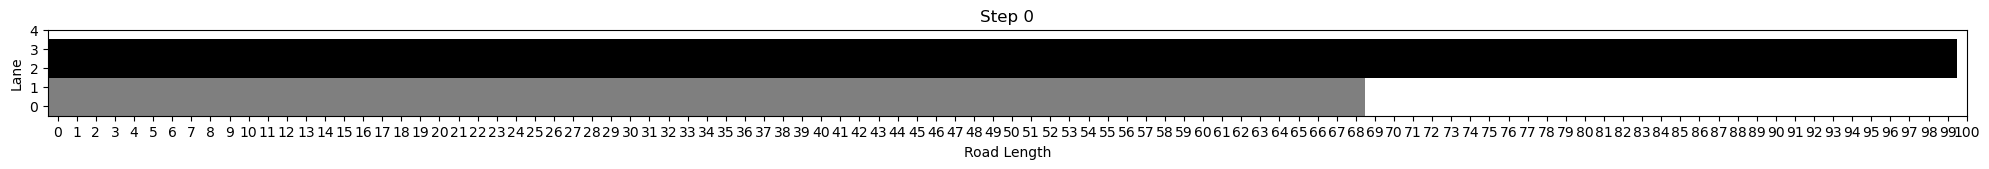

calling lane changing method
Vehicle 30 is located at row 0 with a speed of 0
jeep 30's rear bumper is at 45
jeep 30's front bumper is at 47
jeep 30's maximum distance is  0
jeep 30 has a gap distance of 0
jeep30 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 30 has an available space of 0 cells.
jeep 30's rear bumper is at 45
jeep 30's front bumper is at 47
jeep 30's maximum distance is  0
jeep 30 has a gap distance of 0
 The adjacent left lane of jeep 30 has an available space of 0 cells.
jeep 30's rear bumper is at 45
jeep 30's front bumper is at 47
jeep 30's maximum distance is  1
2.0
jeep 30 has a gap distance of 0
calling lane changing method
Vehicle 7 is located at row 2 with a speed of 0
truck 7's rear bumper is at 49
truck 7's front bumper is at 55
truck 7's maximum distance is  0
truck 7 has a gap distance of 0
truck7 has a gap distance of 0 in its lane, vehicle row is 2
truck 7's rear bumper is at 49
truck 7's front bumper is at 55
tru

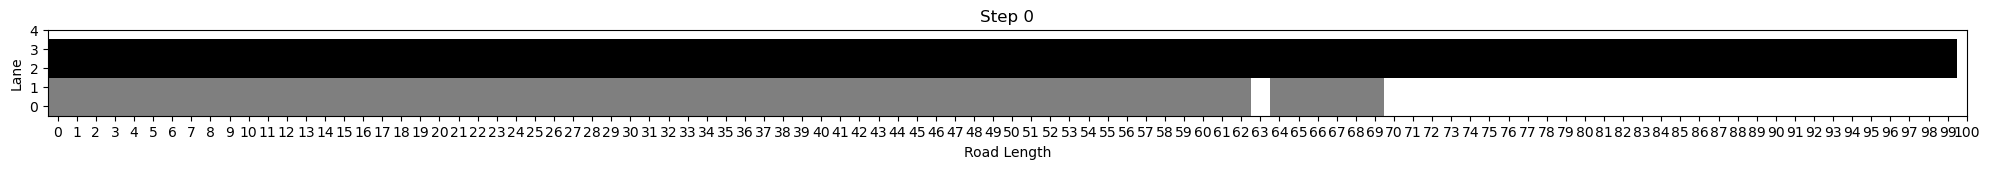

calling lane changing method
Vehicle 23 is located at row 0 with a speed of 0
jeep 23's rear bumper is at 24
jeep 23's front bumper is at 26
jeep 23's maximum distance is  0
jeep 23 has a gap distance of 0
jeep23 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 23 has an available space of 0 cells.
jeep 23's rear bumper is at 24
jeep 23's front bumper is at 26
jeep 23's maximum distance is  0
jeep 23 has a gap distance of 0
 The adjacent left lane of jeep 23 has an available space of 0 cells.
jeep 23's rear bumper is at 24
jeep 23's front bumper is at 26
jeep 23's maximum distance is  1
2.0
jeep 23 has a gap distance of 0
calling lane changing method
Vehicle 29 is located at row 0 with a speed of 0
jeep 29's rear bumper is at 42
jeep 29's front bumper is at 44
jeep 29's maximum distance is  0
jeep 29 has a gap distance of 0
jeep29 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 29 has an available space of 0 c

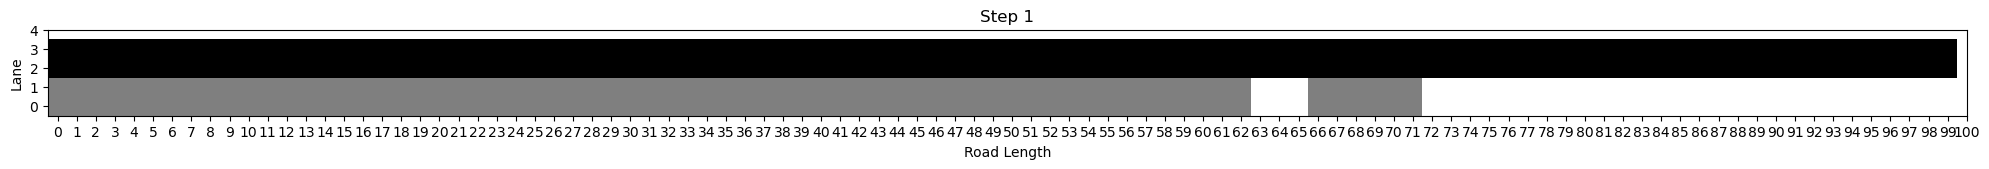

calling lane changing method
Vehicle 15 is located at row 0 with a speed of 0
jeep 15's rear bumper is at 0
jeep 15's front bumper is at 2
jeep 15's maximum distance is  0
jeep 15 has a gap distance of 0
jeep15 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 15 has an available space of 0 cells.
jeep 15's rear bumper is at 0
jeep 15's front bumper is at 2
jeep 15's maximum distance is  0
jeep 15 has a gap distance of 0
 The adjacent left lane of jeep 15 has an available space of 0 cells.
jeep 15's rear bumper is at 0
jeep 15's front bumper is at 2
jeep 15's maximum distance is  1
2.0
jeep 15 has a gap distance of 0
calling lane changing method
Vehicle 2 is located at row 2 with a speed of 0
truck 2's rear bumper is at 14
truck 2's front bumper is at 20
truck 2's maximum distance is  0
truck 2 has a gap distance of 0
truck2 has a gap distance of 0 in its lane, vehicle row is 2
truck 2's rear bumper is at 14
truck 2's front bumper is at 20
truck 2's

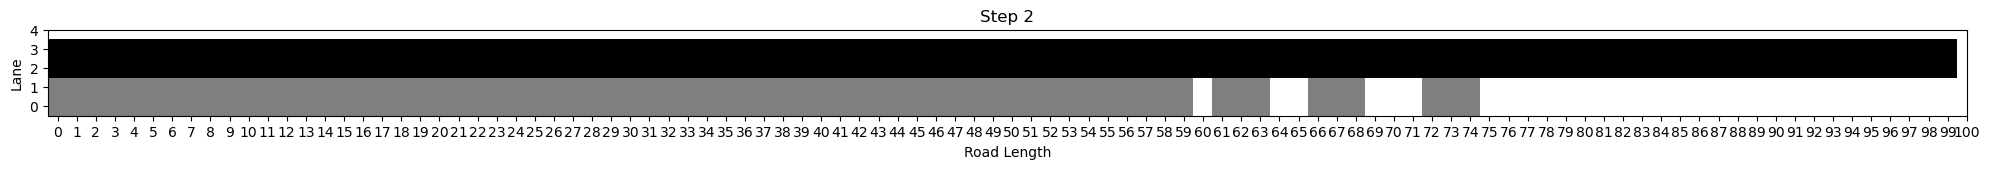

calling lane changing method
Vehicle 1 is located at row 2 with a speed of 0
truck 1's rear bumper is at 7
truck 1's front bumper is at 13
truck 1's maximum distance is  0
truck 1 has a gap distance of 0
truck1 has a gap distance of 0 in its lane, vehicle row is 2
truck 1's rear bumper is at 7
truck 1's front bumper is at 13
truck 1's maximum distance is  0
truck 1 has a gap distance of 0
 The adjacent right lane of truck 1 has an available space of 0 cells.
 The adjacent left lane of truck 1 has an available space of 0 cells.
truck 1's rear bumper is at 7
truck 1's front bumper is at 13
truck 1's maximum distance is  1
4.0
truck 1 has a gap distance of 0
calling lane changing method
Vehicle 5 is located at row 2 with a speed of 0
truck 5's rear bumper is at 35
truck 5's front bumper is at 41
truck 5's maximum distance is  0
truck 5 has a gap distance of 0
truck5 has a gap distance of 0 in its lane, vehicle row is 2
truck 5's rear bumper is at 35
truck 5's front bumper is at 41
truck 5

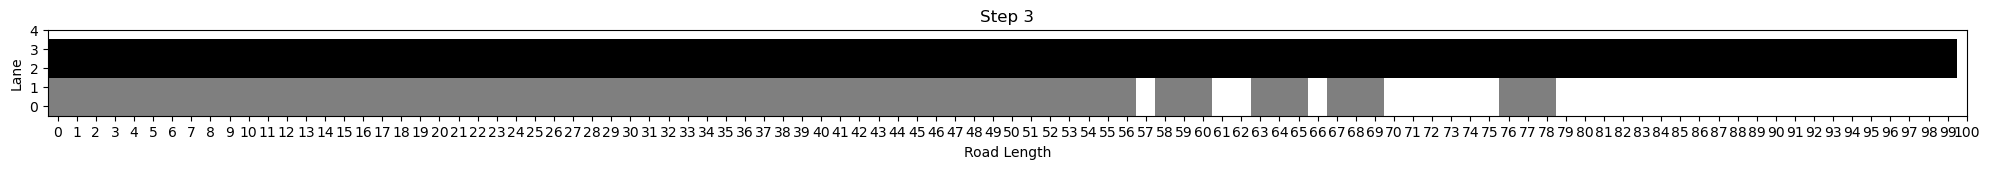

calling lane changing method
Vehicle 28 is located at row 0 with a speed of 0
jeep 28's rear bumper is at 39
jeep 28's front bumper is at 41
jeep 28's maximum distance is  0
jeep 28 has a gap distance of 0
jeep28 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 28 has an available space of 0 cells.
jeep 28's rear bumper is at 39
jeep 28's front bumper is at 41
jeep 28's maximum distance is  0
jeep 28 has a gap distance of 0
 The adjacent left lane of jeep 28 has an available space of 0 cells.
jeep 28's rear bumper is at 39
jeep 28's front bumper is at 41
jeep 28's maximum distance is  1
2.0
jeep 28 has a gap distance of 0
calling lane changing method
Vehicle 6 is located at row 2 with a speed of 0
truck 6's rear bumper is at 42
truck 6's front bumper is at 48
truck 6's maximum distance is  0
truck 6 has a gap distance of 0
truck6 has a gap distance of 0 in its lane, vehicle row is 2
truck 6's rear bumper is at 42
truck 6's front bumper is at 48
tru

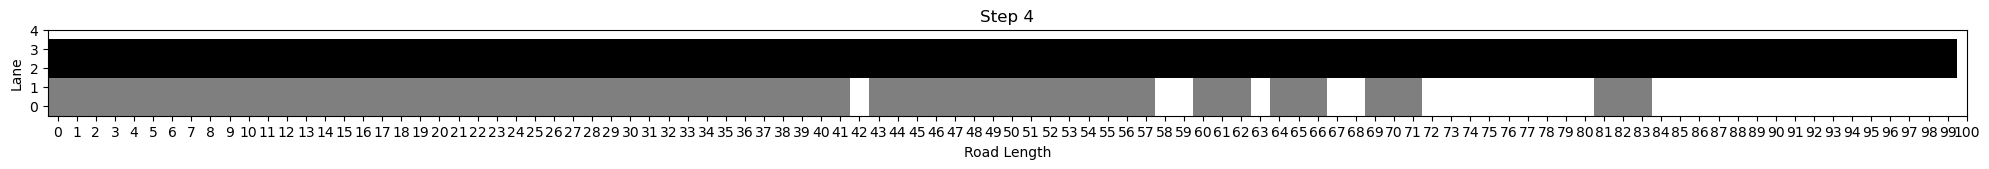

calling lane changing method
Vehicle 25 is located at row 0 with a speed of 0
jeep 25's rear bumper is at 30
jeep 25's front bumper is at 32
jeep 25's maximum distance is  0
jeep 25 has a gap distance of 0
jeep25 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 25 has an available space of 0 cells.
jeep 25's rear bumper is at 30
jeep 25's front bumper is at 32
jeep 25's maximum distance is  0
jeep 25 has a gap distance of 0
 The adjacent left lane of jeep 25 has an available space of 0 cells.
jeep 25's rear bumper is at 30
jeep 25's front bumper is at 32
jeep 25's maximum distance is  1
2.0
jeep 25 has a gap distance of 0
calling lane changing method
Vehicle 22 is located at row 0 with a speed of 0
jeep 22's rear bumper is at 21
jeep 22's front bumper is at 23
jeep 22's maximum distance is  0
jeep 22 has a gap distance of 0
jeep22 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 22 has an available space of 0 c

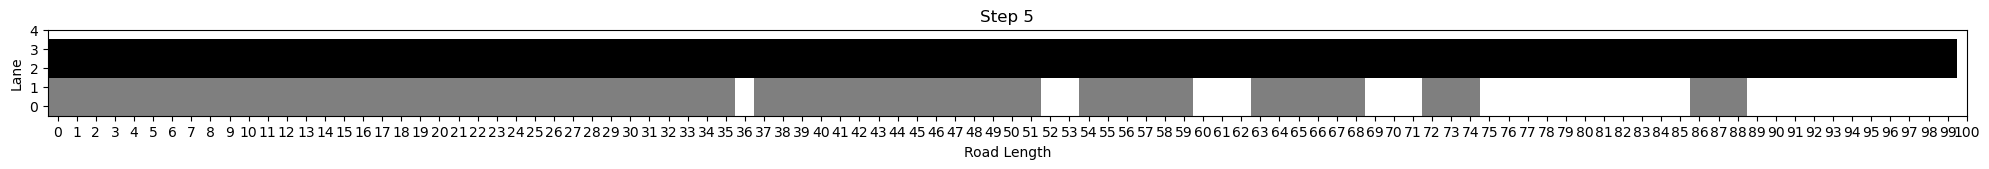

calling lane changing method
Vehicle 35 is located at row 0 with a speed of 2
jeep 35's rear bumper is at 66
jeep 35's front bumper is at 68
jeep 35's maximum distance is  2
jeep 35 has a gap distance of 2
jeep35 has a gap distance of 2 in its lane, vehicle row is 0
 The adjacent right lane of jeep 35 has an available space of 2 cells.
jeep 35's rear bumper is at 66
jeep 35's front bumper is at 68
jeep 35's maximum distance is  2
4.0
jeep 35 has a gap distance of 0
 The adjacent left lane of jeep 35 has an available space of 0 cells.
jeep 35's rear bumper is at 66
jeep 35's front bumper is at 68
jeep 35's maximum distance is  3
jeep 35 has a gap distance of 3
calling lane changing method
Vehicle 27 is located at row 0 with a speed of 1
jeep 27's rear bumper is at 37
jeep 27's front bumper is at 39
jeep 27's maximum distance is  1
2.0
jeep 27 has a gap distance of 0
jeep27 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 27 has an available space of

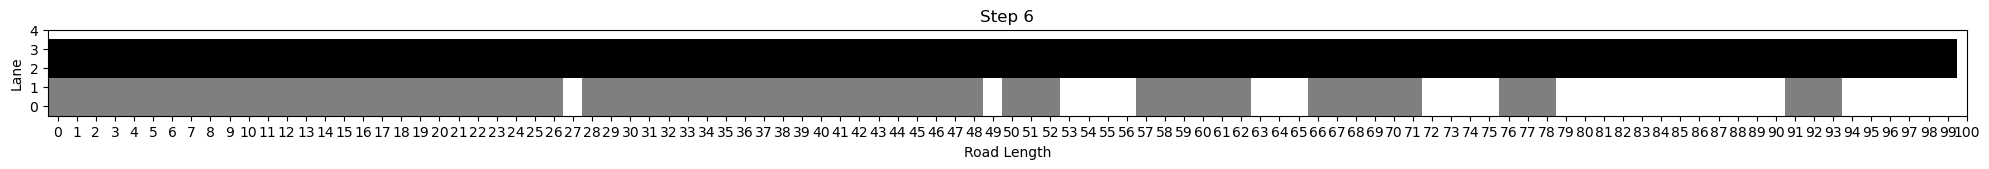

calling lane changing method
Vehicle 34 is located at row 0 with a speed of 3
jeep 34's rear bumper is at 66
jeep 34's front bumper is at 68
jeep 34's maximum distance is  3
2.0
jeep 34 has a gap distance of 0
jeep34 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 34 has an available space of 0 cells.
jeep 34's rear bumper is at 66
jeep 34's front bumper is at 68
jeep 34's maximum distance is  3
4.0
jeep 34 has a gap distance of 0
 The adjacent left lane of jeep 34 has an available space of 0 cells.
jeep 34's rear bumper is at 66
jeep 34's front bumper is at 68
jeep 34's maximum distance is  4
2.0
jeep 34 has a gap distance of 0
calling lane changing method
Vehicle 31 is located at row 0 with a speed of 1
jeep 31's rear bumper is at 50
jeep 31's front bumper is at 52
jeep 31's maximum distance is  1
jeep 31 has a gap distance of 1
jeep31 has a gap distance of 1 in its lane, vehicle row is 0
 The adjacent right lane of jeep 31 has an available spac

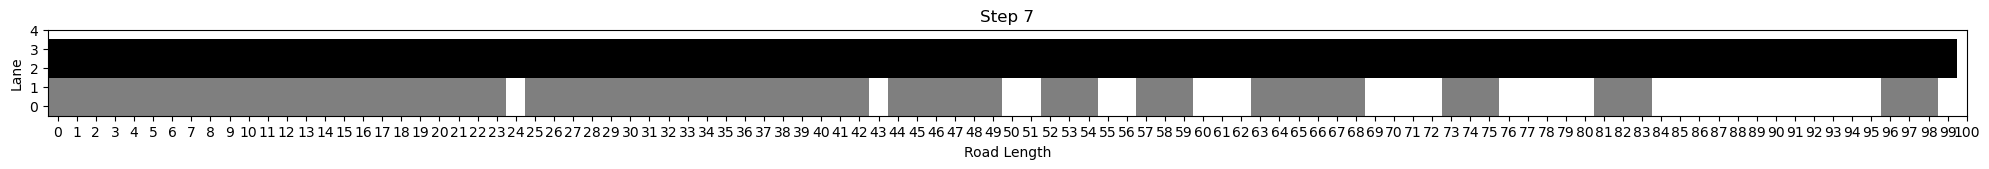

calling lane changing method
Vehicle 28 is located at row 0 with a speed of 0
jeep 28's rear bumper is at 40
jeep 28's front bumper is at 42
jeep 28's maximum distance is  0
jeep 28 has a gap distance of 0
jeep28 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 28 has an available space of 0 cells.
jeep 28's rear bumper is at 40
jeep 28's front bumper is at 42
jeep 28's maximum distance is  0
jeep 28 has a gap distance of 0
 The adjacent left lane of jeep 28 has an available space of 0 cells.
jeep 28's rear bumper is at 40
jeep 28's front bumper is at 42
jeep 28's maximum distance is  1
jeep 28 has a gap distance of 1
calling lane changing method
Vehicle 35 is located at row 0 with a speed of 4
jeep 35's rear bumper is at 73
jeep 35's front bumper is at 75
jeep 35's maximum distance is  4
jeep 35 has a gap distance of 4
jeep35 has a gap distance of 4 in its lane, vehicle row is 0
 The adjacent right lane of jeep 35 has an available space of 4 cells

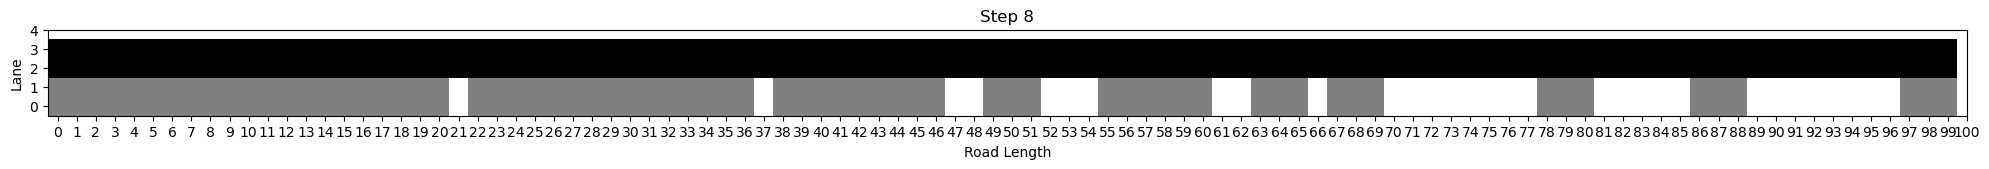

calling lane changing method
Vehicle 11 is located at row 2 with a speed of 0
truck 11's rear bumper is at 77
truck 11's front bumper is at 83
truck 11's maximum distance is  0
truck 11 has a gap distance of 0
truck11 has a gap distance of 0 in its lane, vehicle row is 2
truck 11's rear bumper is at 77
truck 11's front bumper is at 83
truck 11's maximum distance is  0
truck 11 has a gap distance of 0
 The adjacent right lane of truck 11 has an available space of 0 cells.
 The adjacent left lane of truck 11 has an available space of 0 cells.
truck 11's rear bumper is at 77
truck 11's front bumper is at 83
truck 11's maximum distance is  1
4.0
truck 11 has a gap distance of 0
calling lane changing method
Vehicle 26 is located at row 0 with a speed of 0
jeep 26's rear bumper is at 34
jeep 26's front bumper is at 36
jeep 26's maximum distance is  0
jeep 26 has a gap distance of 0
jeep26 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 26 has an availab

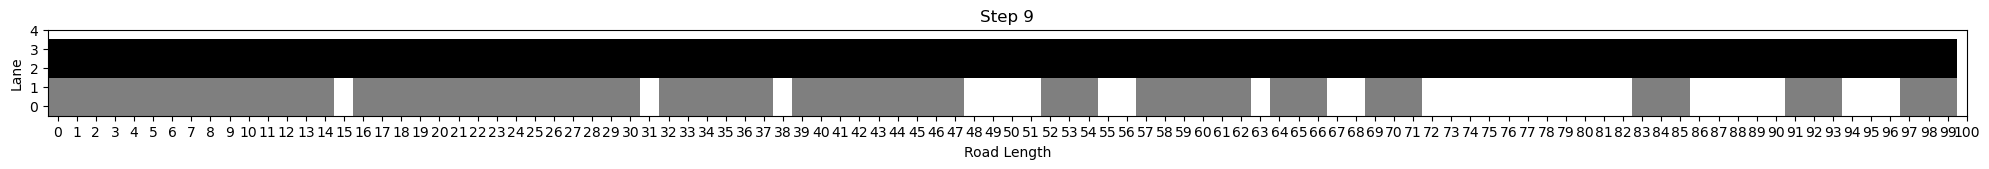

calling lane changing method
Vehicle 33 is located at row 0 with a speed of 1
jeep 33's rear bumper is at 64
jeep 33's front bumper is at 66
jeep 33's maximum distance is  1
jeep 33 has a gap distance of 1
jeep33 has a gap distance of 1 in its lane, vehicle row is 0
 The adjacent right lane of jeep 33 has an available space of 1 cells.
jeep 33's rear bumper is at 64
jeep 33's front bumper is at 66
jeep 33's maximum distance is  1
4.0
jeep 33 has a gap distance of 0
 The adjacent left lane of jeep 33 has an available space of 0 cells.
jeep 33's rear bumper is at 64
jeep 33's front bumper is at 66
jeep 33's maximum distance is  2
jeep 33 has a gap distance of 2
calling lane changing method
Vehicle 25 is located at row 0 with a speed of 1
jeep 25's rear bumper is at 32
jeep 25's front bumper is at 34
jeep 25's maximum distance is  1
2.0
jeep 25 has a gap distance of 0
jeep25 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 25 has an available space of

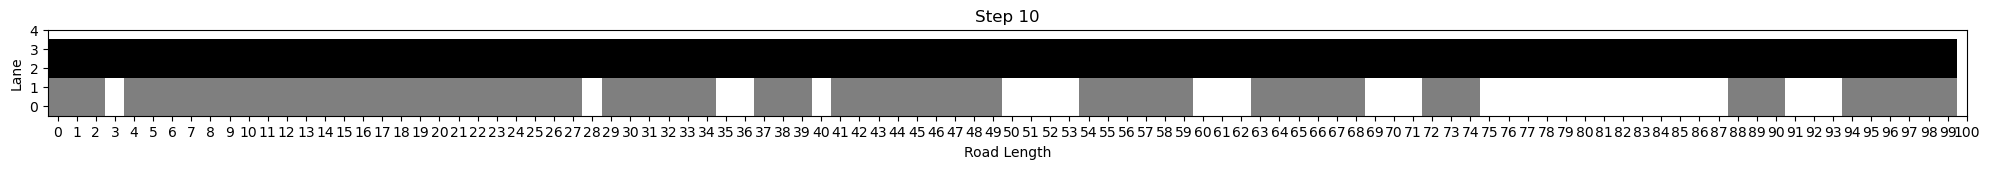

calling lane changing method
Vehicle 5 is located at row 2 with a speed of 0
truck 5's rear bumper is at 35
truck 5's front bumper is at 41
truck 5's maximum distance is  0
truck 5 has a gap distance of 0
truck5 has a gap distance of 0 in its lane, vehicle row is 2
truck 5's rear bumper is at 35
truck 5's front bumper is at 41
truck 5's maximum distance is  0
truck 5 has a gap distance of 0
 The adjacent right lane of truck 5 has an available space of 0 cells.
 The adjacent left lane of truck 5 has an available space of 0 cells.
truck 5's rear bumper is at 35
truck 5's front bumper is at 41
truck 5's maximum distance is  1
4.0
truck 5 has a gap distance of 0
calling lane changing method
Vehicle 2 is located at row 2 with a speed of 0
truck 2's rear bumper is at 14
truck 2's front bumper is at 20
truck 2's maximum distance is  0
truck 2 has a gap distance of 0
truck2 has a gap distance of 0 in its lane, vehicle row is 2
truck 2's rear bumper is at 14
truck 2's front bumper is at 20
truc

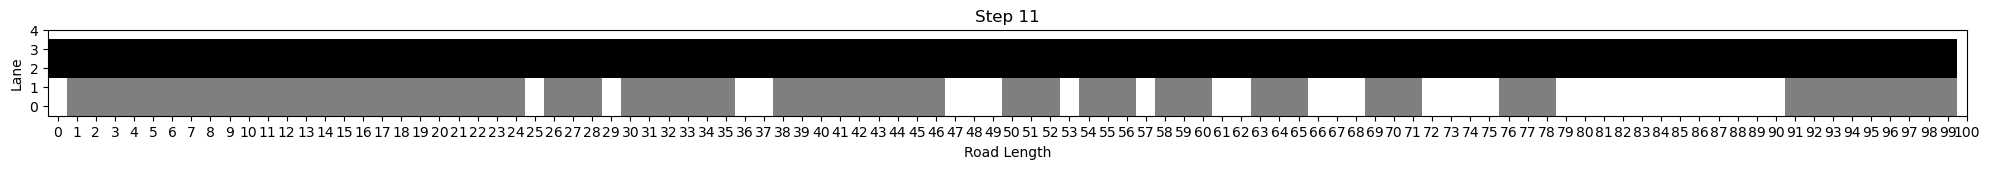

calling lane changing method
Vehicle 0 is located at row 2 with a speed of 0
truck 0's rear bumper is at 0
truck 0's front bumper is at 6
truck 0's maximum distance is  0
truck 0 has a gap distance of 0
truck0 has a gap distance of 0 in its lane, vehicle row is 2
truck 0's rear bumper is at 0
truck 0's front bumper is at 6
truck 0's maximum distance is  0
truck 0 has a gap distance of 0
 The adjacent right lane of truck 0 has an available space of 0 cells.
 The adjacent left lane of truck 0 has an available space of 0 cells.
truck 0's rear bumper is at 0
truck 0's front bumper is at 6
truck 0's maximum distance is  1
4.0
truck 0 has a gap distance of 0
calling lane changing method
Vehicle 10 is located at row 2 with a speed of 0
truck 10's rear bumper is at 70
truck 10's front bumper is at 76
truck 10's maximum distance is  0
truck 10 has a gap distance of 0
truck10 has a gap distance of 0 in its lane, vehicle row is 2
truck 10's rear bumper is at 70
truck 10's front bumper is at 76
tr

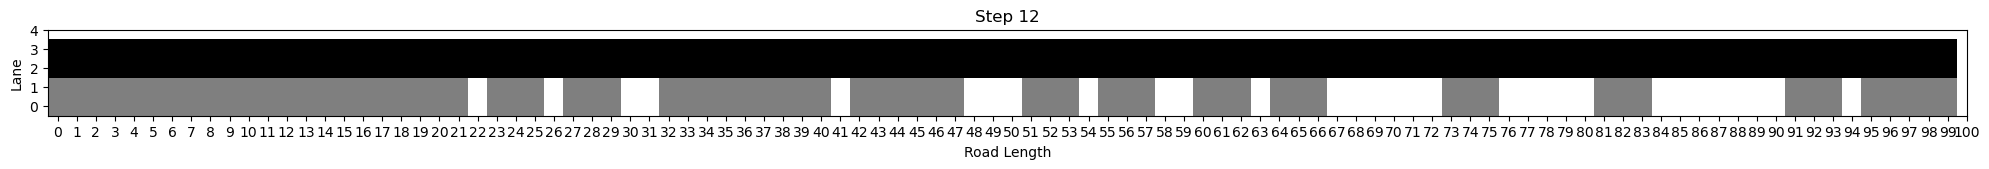

calling lane changing method
Vehicle 11 is located at row 2 with a speed of 0
truck 11's rear bumper is at 77
truck 11's front bumper is at 83
truck 11's maximum distance is  0
truck 11 has a gap distance of 0
truck11 has a gap distance of 0 in its lane, vehicle row is 2
truck 11's rear bumper is at 77
truck 11's front bumper is at 83
truck 11's maximum distance is  0
truck 11 has a gap distance of 0
 The adjacent right lane of truck 11 has an available space of 0 cells.
 The adjacent left lane of truck 11 has an available space of 0 cells.
truck 11's rear bumper is at 77
truck 11's front bumper is at 83
truck 11's maximum distance is  1
4.0
truck 11 has a gap distance of 0
calling lane changing method
Vehicle 37 is located at row 0 with a speed of 1
jeep 37's rear bumper is at 98
jeep 37's front bumper is at 100
jeep 37's maximum distance is  1
2.0
jeep 37 has a gap distance of 0
jeep37 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 37 has an av

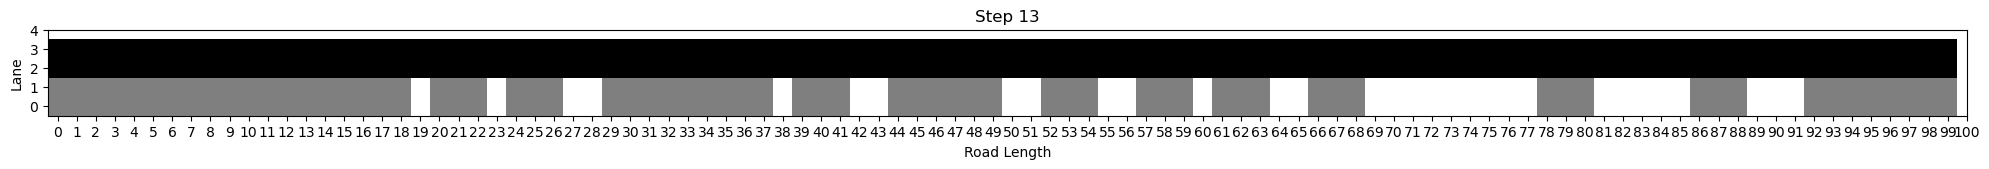

calling lane changing method
Vehicle 1 is located at row 2 with a speed of 0
truck 1's rear bumper is at 7
truck 1's front bumper is at 13
truck 1's maximum distance is  0
truck 1 has a gap distance of 0
truck1 has a gap distance of 0 in its lane, vehicle row is 2
truck 1's rear bumper is at 7
truck 1's front bumper is at 13
truck 1's maximum distance is  0
truck 1 has a gap distance of 0
 The adjacent right lane of truck 1 has an available space of 0 cells.
 The adjacent left lane of truck 1 has an available space of 0 cells.
truck 1's rear bumper is at 7
truck 1's front bumper is at 13
truck 1's maximum distance is  1
4.0
truck 1 has a gap distance of 0
calling lane changing method
Vehicle 35 is located at row 0 with a speed of 1
jeep 35's rear bumper is at 92
jeep 35's front bumper is at 94
jeep 35's maximum distance is  1
2.0
jeep 35 has a gap distance of 0
jeep35 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 35 has an available space of 0 c

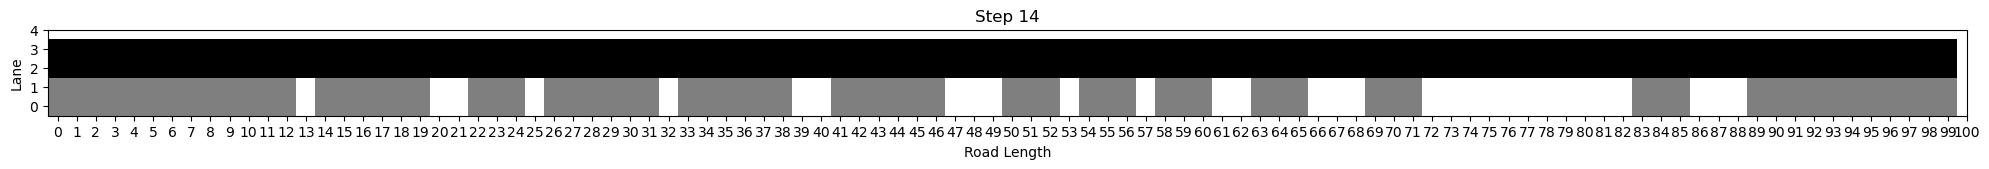

calling lane changing method
Vehicle 37 is located at row 0 with a speed of 0
jeep 37's rear bumper is at 98
jeep 37's front bumper is at 100
jeep 37's maximum distance is  0
jeep 37 has a gap distance of 0
jeep37 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 37 has an available space of 0 cells.
jeep 37's rear bumper is at 98
jeep 37's front bumper is at 100
jeep 37's maximum distance is  0
jeep 37 has a gap distance of 0
 The adjacent left lane of jeep 37 has an available space of 0 cells.
jeep 37's rear bumper is at 98
jeep 37's front bumper is at 100
jeep 37's maximum distance is  1
2.0
jeep 37 has a gap distance of 0
calling lane changing method
Vehicle 31 is located at row 0 with a speed of 2
jeep 31's rear bumper is at 63
jeep 31's front bumper is at 65
jeep 31's maximum distance is  2
jeep 31 has a gap distance of 2
jeep31 has a gap distance of 2 in its lane, vehicle row is 0
 The adjacent right lane of jeep 31 has an available space of 

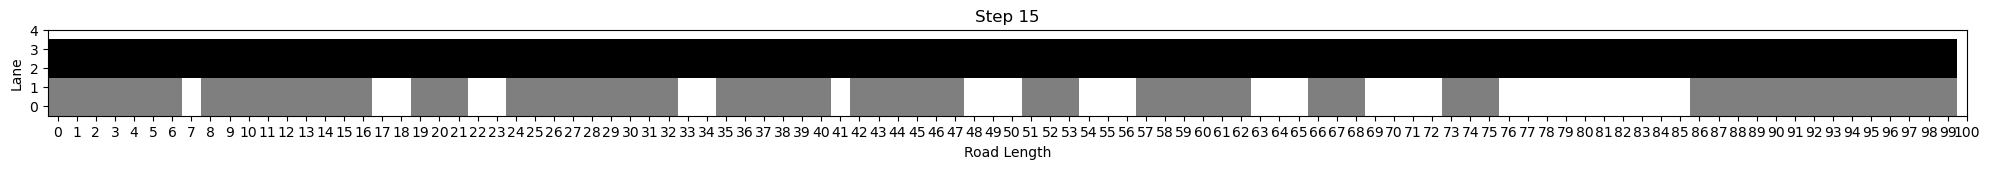

calling lane changing method
Vehicle 32 is located at row 0 with a speed of 4
jeep 32's rear bumper is at 73
jeep 32's front bumper is at 75
jeep 32's maximum distance is  4
jeep 32 has a gap distance of 4
jeep32 has a gap distance of 4 in its lane, vehicle row is 0
 The adjacent right lane of jeep 32 has an available space of 4 cells.
jeep 32's rear bumper is at 73
jeep 32's front bumper is at 75
jeep 32's maximum distance is  4
4.0
jeep 32 has a gap distance of 0
 The adjacent left lane of jeep 32 has an available space of 0 cells.
jeep 32's rear bumper is at 73
jeep 32's front bumper is at 75
jeep 32's maximum distance is  5
jeep 32 has a gap distance of 5
calling lane changing method
Vehicle 21 is located at row 0 with a speed of 2
jeep 21's rear bumper is at 24
jeep 21's front bumper is at 26
jeep 21's maximum distance is  2
2.0
jeep 21 has a gap distance of 0
jeep21 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 21 has an available space of

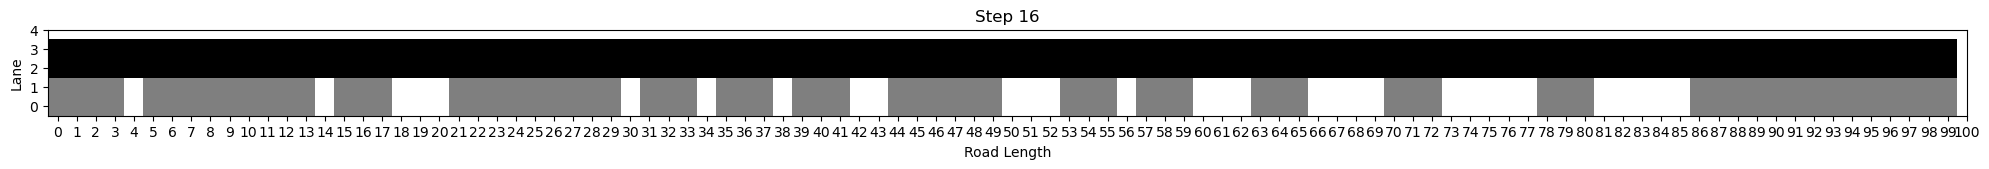

calling lane changing method
Vehicle 4 is located at row 2 with a speed of 0
truck 4's rear bumper is at 28
truck 4's front bumper is at 34
truck 4's maximum distance is  0
truck 4 has a gap distance of 0
truck4 has a gap distance of 0 in its lane, vehicle row is 2
truck 4's rear bumper is at 28
truck 4's front bumper is at 34
truck 4's maximum distance is  0
truck 4 has a gap distance of 0
 The adjacent right lane of truck 4 has an available space of 0 cells.
 The adjacent left lane of truck 4 has an available space of 0 cells.
truck 4's rear bumper is at 28
truck 4's front bumper is at 34
truck 4's maximum distance is  1
4.0
truck 4 has a gap distance of 0
calling lane changing method
Vehicle 17 is located at row 0 with a speed of 0
jeep 17's rear bumper is at 8
jeep 17's front bumper is at 10
jeep 17's maximum distance is  0
jeep 17 has a gap distance of 0
jeep17 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 17 has an available space of 0 cel

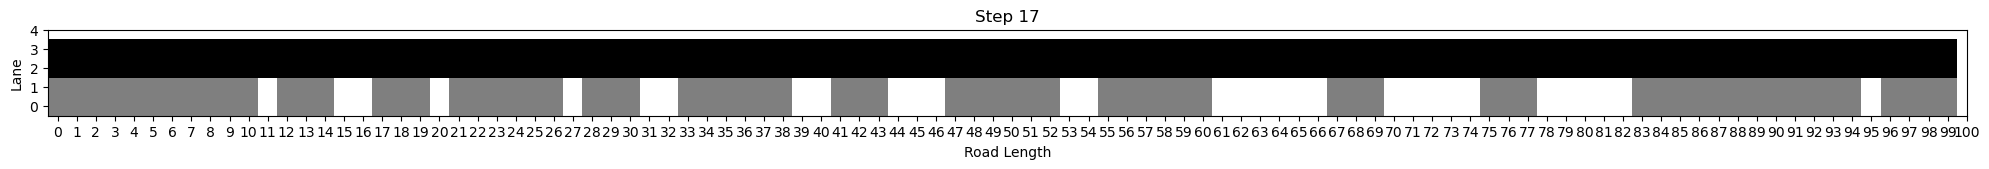

calling lane changing method
Vehicle 25 is located at row 0 with a speed of 2
jeep 25's rear bumper is at 41
jeep 25's front bumper is at 43
jeep 25's maximum distance is  2
jeep 25 has a gap distance of 2
jeep25 has a gap distance of 2 in its lane, vehicle row is 0
 The adjacent right lane of jeep 25 has an available space of 2 cells.
jeep 25's rear bumper is at 41
jeep 25's front bumper is at 43
jeep 25's maximum distance is  2
4.0
jeep 25 has a gap distance of 0
 The adjacent left lane of jeep 25 has an available space of 0 cells.
jeep 25's rear bumper is at 41
jeep 25's front bumper is at 43
jeep 25's maximum distance is  3
jeep 25 has a gap distance of 3
calling lane changing method
Vehicle 17 is located at row 0 with a speed of 0
jeep 17's rear bumper is at 8
jeep 17's front bumper is at 10
jeep 17's maximum distance is  0
jeep 17 has a gap distance of 0
jeep17 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 17 has an available space of 0 ce

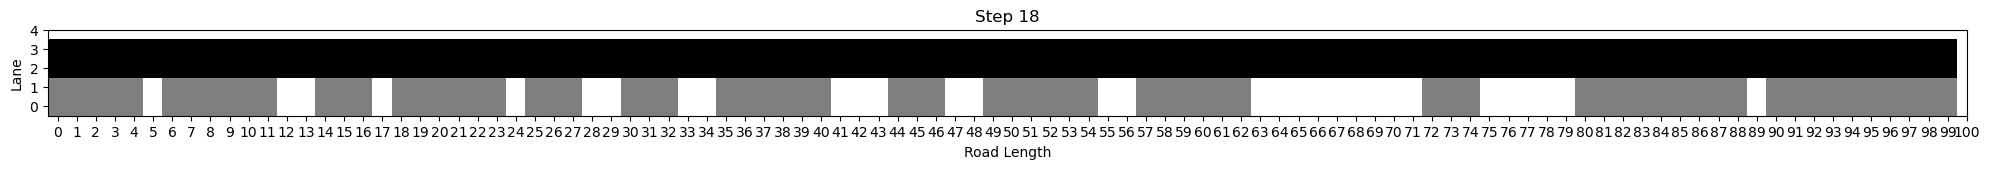

calling lane changing method
Vehicle 18 is located at row 0 with a speed of 2
jeep 18's rear bumper is at 14
jeep 18's front bumper is at 16
jeep 18's maximum distance is  2
2.0
jeep 18 has a gap distance of 1
jeep18 has a gap distance of 1 in its lane, vehicle row is 0
 The adjacent right lane of jeep 18 has an available space of 1 cells.
jeep 18's rear bumper is at 14
jeep 18's front bumper is at 16
jeep 18's maximum distance is  2
4.0
jeep 18 has a gap distance of 0
 The adjacent left lane of jeep 18 has an available space of 0 cells.
jeep 18's rear bumper is at 14
jeep 18's front bumper is at 16
jeep 18's maximum distance is  3
2.0
jeep 18 has a gap distance of 1
calling lane changing method
Vehicle 20 is located at row 0 with a speed of 0
jeep 20's rear bumper is at 21
jeep 20's front bumper is at 23
jeep 20's maximum distance is  0
jeep 20 has a gap distance of 0
jeep20 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 20 has an available spac

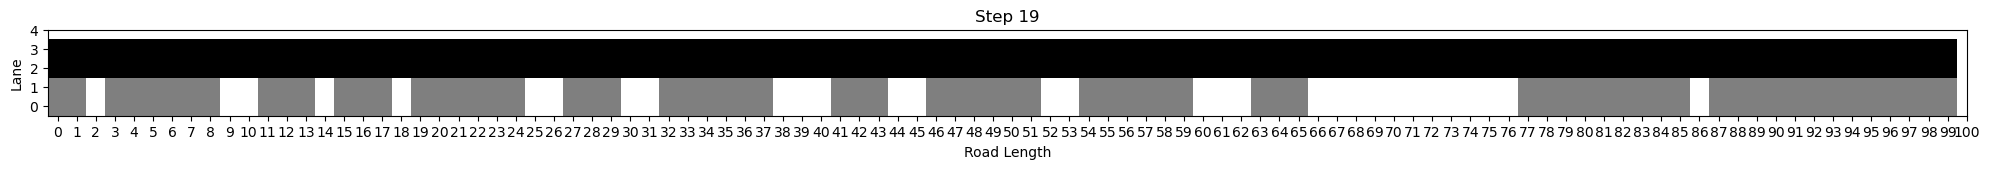

In [5]:
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 1  # Example density
truck_fraction = 0.5 # Example truck fraction
simulator.initialize_vehicles(density, truck_fraction, 1, 1)
simulator.visualize(0)
for step in range(20):
    simulator.simulation_step()
    if step % 1 == 0:
        simulator.visualize(step)

##### MOVING CHECKER

In [ ]:
def animate(step):
    simulator.simulation_step()  # Run a simulation step
    ax.clear()  # Clear the previous plot
    ax.imshow(simulator.road.road_occupancy.T, cmap='gray_r', origin='lower')
    #ax.set_title(f'Time step {step}')
    #ax.set_xlabel('Road Length')
    #ax.set_ylabel('Row')
    #ax.set_xticks(range(0, simulator.road.road_length + 1, 1))
    #ax.set_yticks(range(0, simulator.road.road_width + 1, 1))
    #ax.grid(True)

# Initialize road and simulator
road = Road(road_length=100, road_width=4, speed_limit=5)
simulator = IntraRoadSimulator(road)

density = 0.4
truck_fraction = 0.6

simulator.initialize_vehicles(density, truck_fraction, 0, 0)  # Initialize vehicles

# Set up the figure and axis for animation
fig, ax = plt.subplots(figsize=(30, 12))

# Create the animation
anim = FuncAnimation(fig, animate, frames=1000, interval=300)

# Save the animation as a GIF or MP4
anim.save('road_simulation_jeeptruck_November10,11:28(density=0.4, truck fraction = 0.6, exclusive).gif', writer='pillow')
# Or save as MP4
# anim.save('road_simulation.mp4', writer='ffmpeg')

# Show the animation in a Jupyter notebook (if using one)
plt.show()

OCTOBER 31, 2024 - FUNDAMENTAL DIAGRAM

In [ ]:
import numpy as np
import csv

# Define the road and density parameters
road = Road(road_length=100, road_width=4, speed_limit=5)
densities = np.linspace(0, 1.0, 50)  # Generate 50 density points
total_steps = 500

# Open the CSV file and write the header
with open('fundamental_diagram_october4.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Input Density', 'Actual Density', 'Throughput'])

    # Loop over each density, run the simulation, and write results to the CSV file
    for density in densities:
        simulator = IntraRoadSimulator(road)
        simulator.initialize_vehicles(density, truck_fraction=0.5, truck_lane_change_prob=1, jeep_lane_change_prob=0)

        throughput_counter = ThroughputCounter(position=99)
        occupied_cells = 0  # Counter for occupied cells

        for step in range(total_steps):
            simulator.simulation_step()

            # Count vehicles passing through the specified position
            for vehicle in simulator.vehicles:
                throughput_counter.count_vehicle(vehicle)

            # Track occupied cells each timestep
            occupied_cells += len(simulator.vehicles)

        throughput = throughput_counter.calculate_throughput()
        actual_density = occupied_cells / (total_steps * road.road_length * road.road_width)

        # Write input density, actual density, and throughput to the CSV file
        writer.writerow([density, actual_density, throughput])

In [7]:
# Define the road and density parameters
road = Road(road_length=100, road_width=4, speed_limit=5)
densities = np.linspace(0, 1.0, 50)  # Generate 50 density points
total_steps = 500

# Open the CSV file and write the header for density and throughput
with open('fundamental_diagram_october31.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Input Density', 'Actual Density', 'Throughput'])

    # Loop over each density, run the simulation, and write results to the CSV file
    for density in densities:
        simulator = IntraRoadSimulator(road)
        simulator.initialize_vehicles(density, truck_fraction=0.2, truck_lane_change_prob=1, jeep_lane_change_prob=1)

        throughput_counter = ThroughputCounter(position=99)
        occupied_cells = 0  # Counter for occupied cells
        
        # Prepare a dictionary to store spatio-temporal data for each lane
        lane_data = {lane: [] for lane in range(road.road_width)}

        for step in range(total_steps):
            simulator.simulation_step()

            # Count vehicles passing through the specified position
            for vehicle in simulator.vehicles:
                throughput_counter.count_vehicle(vehicle)

                # Collect spatio-temporal data
                lane_data[vehicle.lane].append((step, vehicle.position))
            
            # Track occupied cells each timestep
            occupied_cells += len(simulator.vehicles)

        throughput = throughput_counter.calculate_throughput()
        actual_density = occupied_cells / (total_steps * road.road_length * road.road_width)

        # Write input density, actual density, and throughput to the CSV file
        writer.writerow([density, actual_density, throughput])

        # Plot spatio-temporal graphs for each lane
        plt.figure(figsize=(10, 8))
        for lane, data in lane_data.items():
            # Extract steps and positions for each lane
            steps, positions = zip(*data) if data else ([], [])
            plt.scatter(positions, steps, s=1, label=f'Lane {lane}')

        plt.xlabel('Position')
        plt.ylabel('Time Step')
        plt.title(f'Spatio-Temporal Diagram for Density {density:.2f}')
        plt.legend()
        plt.gca().invert_yaxis()  # Optional: time increasing downward for clarity
        plt.savefig(f'spatio_temporal_density_{density:.2f}.png')
        plt.close()

jeep 752 attributes
calling lane changing method
Vehicle 752 is located at row 0 with a speed of 0
jeep 752's rear bumper is at 0
jeep 752's front bumper is at 2
jeep 752's maximum distance is  0
jeep 752 has a gap distance of 0
jeep752 has a gap distance of 0 in its lane, vehicle row is 0
 The adjacent right lane of jeep 752 has an available space of 0 cells.
jeep 752's rear bumper is at 0
jeep 752's front bumper is at 2
jeep 752's maximum distance is  0
jeep 752 has a gap distance of 0
 The adjacent left lane of jeep 752 has an available space of 0 cells.
jeep 752's rear bumper is at 0
jeep 752's front bumper is at 2
jeep 752's maximum distance is  1
jeep 752 has a gap distance of 1


AttributeError: 'Vehicle' object has no attribute 'lane'

OLD ATTEMPTS TO SAVE AS A CSV FILE ( NO LONGER FUNCTIONING)

In [ ]:
# Parameters
density_values = np.linspace(0.1, 1, 20)
timesteps = 1000
truck_fraction = 0.3
output_dir = "density_throughput_output"
os.makedirs(output_dir, exist_ok=True)

# Run simulation for each density
for density in density_values:
    road = Road(road_length=200, road_width=4, speed_limit=5)
    throughput_counter = ThroughputCounter(position=road.road_length)
    simulator = IntraRoadSimulator(road, throughput_counter)
    simulator.initialize_vehicles(density, truck_fraction, 1, 0)
    
    # Simulate timesteps
    for step in range(timesteps):
        simulator.simulation_step()

    # Calculate average throughput
    avg_throughput = throughput_counter.vehicle_throughput / timesteps

    # Write to CSV
    csv_filename = os.path.join(output_dir, f'density_{density:.2f}.csv')
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Density", "Average Throughput"])
        writer.writerow([density, avg_throughput])
    
    print(f"Density: {density:.2f}, Average Throughput: {avg_throughput}")

print("Average throughput calculation for all densities is complete.")

In [ ]:
# Define the density values you want to test
density_values = np.linspace(0, 1, 20)  # Example: 8 density points from 0.05 to 0.4
timesteps = 1000
truck_fraction = 0.3

# Create a directory to store the CSV files
output_dir = "density_timesteps_output2"
os.makedirs(output_dir, exist_ok=True)

for density in density_values:
    road = Road(road_length=200, road_width=4, speed_limit=5)
    simulator = IntraRoadSimulator(road)
    simulator.initialize_vehicles(density, truck_fraction, 1, 0)
    
    csv_filename = os.path.join(output_dir, f'density_{density:.2f}.csv')
    
    # Open the CSV file for writing
    with open(csv_filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Timestep", "Throughput"])
        
        for step in range(timesteps):
            simulator.simulation_step(density, truck_fraction)
            throughput_at_step = simulator.vehicle_throughput
            writer.writerow([step + 1, throughput_at_step])
            
    print(f'Saved: {csv_filename}')

print("CSV files for all densities and timesteps have been saved.")